In [1]:
import os
import cv2
import numpy as np
from tqdm import tqdm

In [2]:
REBUILD_DATA = False # set to true to one once, then back to false unless you want to change something in your training data.

class DogsVSCats():
    IMG_SIZE = 50
    CATS = "PetImages/Cat"
    DOGS = "PetImages/Dog"
    TESTING = "PetImages/Testing"
    LABELS = {CATS: 0, DOGS: 1}
    training_data = []

    catcount = 0
    dogcount = 0

    def make_training_data(self):
        for label in self.LABELS:
            print(label)
            for f in tqdm(os.listdir(label)):
                if "jpg" in f:
                    try:
                        path = os.path.join(label, f)
                        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                        img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
                        self.training_data.append([np.array(img), np.eye(2)[self.LABELS[label]]])  # do something like print(np.eye(2)[1]), just makes one_hot 
                        #print(np.eye(2)[self.LABELS[label]])

                        if label == self.CATS:
                            self.catcount += 1
                        elif label == self.DOGS:
                            self.dogcount += 1

                    except Exception as e:
                        pass
                        #print(label, f, str(e))

        np.random.shuffle(self.training_data)
        np.save("training_data.npy", self.training_data)
        print('Cats:',dogsvcats.catcount)
        print('Dogs:',dogsvcats.dogcount)

if REBUILD_DATA:
    dogsvcats = DogsVSCats()
    dogsvcats.make_training_data()

In [3]:
training_data = np.load("training_data.npy", allow_pickle=True)
print(len(training_data))

24946


In [20]:
import torch

X = torch.Tensor([i[0] for i in training_data]).view(-1, 50, 50)
X = X/255.0
y = torch.Tensor([i[1] for i in training_data])

tensor([0., 1.])


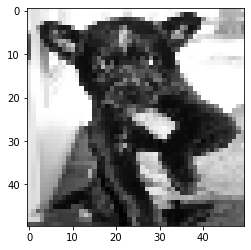

In [5]:
import matplotlib.pyplot as plt

plt.imshow(X[10], cmap = 'gray')
print(y[10])

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [8]:
class Net(nn.Module):
    def __init__(self):
        super().__init__() # just run the init of parent class (nn.Module)
        self.conv1 = nn.Conv2d(1, 32, 5) # input is 1 image, 32 output channels, 5x5 kernel / window
        self.conv2 = nn.Conv2d(32, 64, 5) # input is 32, bc the first layer output 32. Then we say the output will be 64 channels, 5x5 kernel / window
        self.conv3 = nn.Conv2d(64, 128, 5)

        x = torch.randn(50,50).view(-1,1,50,50)
        self._to_linear = None
        self.convs(x)

        self.fc1 = nn.Linear(self._to_linear, 512) #flattening.
        self.fc2 = nn.Linear(512, 2) # 512 in, 2 out bc we're doing 2 classes (dog vs cat).

    def convs(self, x):
        # max pooling over 2x2
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2, 2))

        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
        return x

    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)  # .view is reshape ... this flattens X before 
        x = F.relu(self.fc1(x))
        x = self.fc2(x) # bc this is our output layer. No activation here.
        return F.softmax(x, dim=1)


net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=512, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)


In [44]:
import torch.optim as optim

optimizer = optim.Adam(net.parameters(), lr = 0.001)
loss_function = nn.MSELoss().to(device)

In [11]:
#we want to split our data into test and train
#We will leave 10% of our data for validation

VAL_PCT = 0.1
val_size = int(len(X)*VAL_PCT)
print(val_size)

2494


In [22]:
train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]

In [24]:
print(len(train_X), len(test_X))

22452 2494


In [45]:
BATCH_SIZE = 100
EPOCHS = 5

for epoch in range(EPOCHS):
    for i in tqdm(range(0, len(train_X), BATCH_SIZE)): #From 0, to len of x, stepping BATCH_SIZE at a time.
        batch_X = train_X[i:i + BATCH_SIZE].view(-1, 1, 50, 50)
        batch_y = train_y[i: i + BATCH_SIZE]
        
        net.zero_grad()
        
        outputs = net(batch_X)
        #print(outputs.shape, batch_y.shape)
        loss = loss_function(outputs, batch_y)
        loss.backward()
        optimizer.step() #Does update
        
    print(f"EPOCH: {epoch}, Loss: {loss}")

  3%|▎         | 7/225 [00:00<00:04, 44.59it/s]

EPOCH: 0, Loss: 0.10039959847927094


  3%|▎         | 7/225 [00:00<00:04, 47.58it/s]

EPOCH: 1, Loss: 0.06765435636043549


  3%|▎         | 7/225 [00:00<00:04, 45.49it/s]

EPOCH: 2, Loss: 0.07089850306510925


  3%|▎         | 7/225 [00:00<00:04, 44.80it/s]

EPOCH: 3, Loss: 0.0341411717236042


100%|██████████| 225/225 [00:31<00:00,  7.16it/s]


EPOCH: 4, Loss: 0.027200011536478996


In [30]:
correct = 0
total = 0

with torch.no_grad():
    for i in tqdm(range(len(test_X))):
        real_class = torch.argmax(test_y[i])
        net_out = net(test_X[i].view(-1, 1, 50, 50))[0] #return a list,
        predicted_class = torch.argmax(net_out)
        
        if predicted_class == real_class:
            correct += 1
        total += 1

print("Accuracy: ", round(correct/total, 3))

100%|██████████| 2494/2494 [00:01<00:00, 1280.06it/s]

Accuracy:  0.754


In [31]:
torch.cuda.is_available()

True

In [32]:
device = torch.device("cuda:0")
device

device(type='cuda', index=0)

In [40]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Running on the GPU")

else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


In [42]:
net = net.to(device)

In [46]:
BATCH_SIZE = 100
EPOCHS = 5

train_X = train_X.cuda()
train_y = train_y.cuda()

for epoch in range(EPOCHS):
    for i in tqdm(range(0, len(train_X), BATCH_SIZE)): #From 0, to len of x, stepping BATCH_SIZE at a time.
        batch_X = train_X[i:i + BATCH_SIZE].view(-1, 1, 50, 50)
        batch_y = train_y[i: i + BATCH_SIZE]
        
        net.zero_grad()
        
        outputs = net(batch_X)
        #print(outputs.shape, batch_y.shape)
        loss = loss_function(outputs, batch_y)
        loss.backward()
        optimizer.step() #Does update
        
    print(f"EPOCH: {epoch}, Loss: {loss}")

  3%|▎         | 7/225 [00:00<00:04, 48.67it/s]

EPOCH: 0, Loss: 0.029753349721431732


  3%|▎         | 7/225 [00:00<00:04, 49.22it/s]

EPOCH: 1, Loss: 0.033488884568214417


  3%|▎         | 7/225 [00:00<00:04, 44.45it/s]

EPOCH: 2, Loss: 0.0300765261054039


  3%|▎         | 7/225 [00:00<00:04, 48.68it/s]

EPOCH: 3, Loss: 0.04439054802060127


100%|██████████| 225/225 [00:31<00:00,  7.22it/s]


EPOCH: 4, Loss: 0.011787717230618


In [48]:
correct = 0
total = 0

test_X = test_X.cuda()
test_y = test_y.cuda()

with torch.no_grad():
    for i in tqdm(range(len(test_X))):
        real_class = torch.argmax(test_y[i])
        net_out = net(test_X[i].view(-1, 1, 50, 50))[0] #return a list,
        predicted_class = torch.argmax(net_out)
        
        if predicted_class == real_class:
            correct += 1
        total += 1

print("Accuracy: ", round(correct/total, 3))

100%|██████████| 2494/2494 [00:03<00:00, 628.46it/s]

Accuracy:  0.749
